In [1]:
# Standard Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display
import re

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
start_year = 1993
curr_year = datetime.now().year

In [2]:
# Custom API
from sys import path

path.append('../API/fetch')
import data_fetch as fetch

path.append('../API/preprocess')
from data_pipeline import dataset_pipeline, feature_pipeline, bracket_pipeline

path.append('../API/eda')
from data_visualizations import get_yearly_base_rates, get_seed_pairs, format_plot

path.append('../API/model')
from model_selection import get_cv_models
from model_evaluation import evaluate_cv_models, get_classification_report

# Data Fetching

### Perceived Predictors

Naturally, it will be vitally important to scrape available data that is pertinent to deciding the outcome of an NCAA March Madness game between any two given teams. To successfully do so, we must break down what are generally the most influential elements of a basketball team's success.

<br>Overall team performance during the regular season is generally a good indicator of how a team will perform in March Madness. This would be captured by statistics, both basic and advanced, such as the following:
<br>**Season Record (%)
<br>Conference Record (%); could be important given that the tournament is split into regions
<br>Regular Season Record vs. Tourney Opponent (%); set to theoretical discrete probability of 50% if no such matchups exist 
<br>Strength of Schedule (SOS); measures the difficulty of the teams played (higher number = greater difficulty)
<br>Top 25 Ranking (boolean); considered a consensus top-tier team
<br>Shots Made per Game (FG, 3P, FT)
<br>Point Differential per Game; measures how dominant/unsuccessful you are at outscoring your opponent on average
<br>Misc. Team Stats per Game (Rebounds, Assists, Blocks, etc.)**

<br>It's important to note that in the NCAA, more so than the NBA, experienced coaches can have just as much of an impact on a game's outcome as the players themselves. Hence, it's reasonable to assume that the following statistics could also be solid indicators:
**<br>Coach March Madness Appearances
<br>Coach Sweet Sixteen Appearances
<br>Coach Final Four Appearances
<br>Coach Championships Won**

<br>And lastly, we need the data for the structure of the tournaments themselves:
**<br>Favorite Seed
<br>Underdog Seed
<br>Round Number (0-6)
<br>Game Outcome (boolean); did the underdog upset the favorite?**

## Examples

### Team Regular Season Stats

In [3]:
fetch.get_team_data(url=f"https://www.sports-reference.com/cbb/seasons/{start_year}-school-stats.html",
              attrs={'id': 'basic_school_stats'}).head()

,Rk,School,G,W,L,W-L%,SRS,SOS,Unnamed: 8,W.1,...,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF
0,1,Air Force,28,9,19,.321,-7.45,2.05,NaN,3,...,409,584,.700,NaN,965,285,178,109,385,546
1,2,Akron,26,8,18,.308,-10.69,-5.07,NaN,3,...,320,493,.649,NaN,795,316,163,47,352,573
2,3,Alabama-Birmingham,35,21,14,.600,10.82,5.68,NaN,5,...,456,650,.702,NaN,1273,501,246,135,498,650
3,4,Alabama State,27,14,13,.519,-8.48,-9.70,NaN,9,...,541,767,.705,NaN,1049,393,194,42,556,567
4,5,Alabama,29,16,13,.552,9.66,7.83,NaN,7,...,458,702,.652,NaN,1117,337,185,120,487,539


In [4]:
fetch.get_team_data(url=f"https://www.sports-reference.com/cbb/seasons/{start_year}-advanced-school-stats.html", 
              attrs={'id': 'adv_school_stats'}).head()

,Rk,School,G,W,L,W-L%,SRS,SOS,Unnamed: 8,W.1,...,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA
0,1,Air Force,28,9,19,.321,-7.45,2.05,NaN,3,...,.279,.500,49.9,44.3,NaN,9.6,.458,17.4,NaN,.263
1,2,Akron,26,8,18,.308,-10.69,-5.07,NaN,3,...,.277,.517,51.1,54.5,NaN,5.5,.488,18.4,NaN,.241
2,3,Alabama-Birmingham,35,21,14,.600,10.82,5.68,NaN,5,...,.270,.527,52.2,56.4,NaN,9.6,.494,17.8,NaN,.228
3,4,Alabama State,27,14,13,.519,-8.48,-9.70,NaN,9,...,.203,.557,51.3,46.1,NaN,2.8,.518,20.7,NaN,.305
4,5,Alabama,29,16,13,.552,9.66,7.83,NaN,7,...,.299,.541,51.7,43.1,NaN,8.9,.513,19.4,NaN,.271


### Team Rankings

In [5]:
fetch.get_rankings_data(url=f"https://www.sports-reference.com/cbb/seasons/{start_year}-ratings.html").head()

,Team,Top_25
2,North Carolina,1
3,Kentucky,1
4,Duke,1
5,Indiana,1
6,Cincinnati,1


### Coach Tournament Performance

In [6]:
fetch.get_coach_data(url=f"https://www.sports-reference.com/cbb/seasons/{start_year}-coaches.html").head()

,Coach_Team,MM,S16,F4,Champs
2,Air Force,,,,
3,Akron,,,,
4,Alabama,,,,
5,Alabama-Birmingham,11,5,2,
6,Alabama State,,,,


### Tournament Game Data

In [7]:
fetch.get_team_data(url=("https://apps.washingtonpost.com/sports/search/?pri_school_id=&pri_conference=&pri_coach"
                   "=&pri_seed_from=1&pri_seed_to=16&pri_power_conference=&pri_bid_type=&opp_school_id"
                   "=&opp_conference=&opp_coach=&opp_seed_from=1&opp_seed_to=16&opp_power_conference=&opp_bid_type"
                   f"=&game_type=7&from={start_year}&to={start_year}&submit="), 
              attrs={'class': 'search-results'}, header=0).head()

,Year,Round,Seed,Team,Score,Seed.1,Team.1,Score.1
0,1993,National ChampionshipNational Championship,1,Michigan Michigan,71,1,North Carolina North Carolina,77
1,1993,Final FourFinal Four,1,Kentucky Kentucky,78,1,Michigan Michigan,81
2,1993,Final FourFinal Four,1,North Carolina North Carolina,78,2,Kansas Kansas,68
3,1993,Elite EightElite Eight,1,Michigan Michigan,77,7,Temple Temple,72
4,1993,Elite EightElite Eight,1,Kentucky Kentucky,106,3,Florida State Florida State,81


# Data Cleaning

## Data Pipeline

In [8]:
try:
    mm_matchups_df = pd.read_csv(f'{curr_year}_march_madness_hist_data.csv')
except FileNotFoundError:
    mm_matchups_df = dataset_pipeline(np.arange(start_year, curr_year - 1))
    mm_matchups_df.to_csv(f'{curr_year}_march_madness_hist_data.csv', index=False)

mm_matchups_df

,Year,Round,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Underdog_Upset,G_Favorite,W-L%_Favorite,SOS_Favorite,...,FG/Game_Underdog,3P/Game_Underdog,FT/Game_Underdog,ORB/Game_Underdog,TRB/Game_Underdog,AST/Game_Underdog,STL/Game_Underdog,BLK/Game_Underdog,TOV/Game_Underdog,PF/Game_Underdog
0,1993,National Championship,1,North Carolina,1,Michigan,0,38.0,0.895,11.25,...,31.4,4.2,14.9,NaN,41.5,16.3,6.8,5.4,15.6,18.6
1,1993,Final Four,1,Kentucky,1,Michigan,1,34.0,0.882,9.23,...,31.4,4.2,14.9,NaN,41.5,16.3,6.8,5.4,15.6,18.6
2,1993,Final Four,1,North Carolina,2,Kansas,0,38.0,0.895,11.25,...,30.8,6.0,16.8,NaN,36.1,19.1,9.1,2.9,14.5,17.6
3,1993,Elite Eight,1,Indiana,2,Kansas,1,35.0,0.886,11.09,...,30.8,6.0,16.8,NaN,36.1,19.1,9.1,2.9,14.5,17.6
4,1993,Elite Eight,1,North Carolina,2,Cincinnati,0,38.0,0.895,11.25,...,28.1,5.0,13.2,NaN,36.0,16.0,10.0,2.6,14.1,18.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,2019,First Round,7,Wofford,10,Seton Hall,0,35.0,0.857,0.80,...,26.1,7.1,14.5,10.6,35.7,13.5,6.9,3.9,12.4,18.8
1743,2019,First Round,6,Buffalo,11,Arizona State,0,36.0,0.889,2.62,...,26.4,7.1,17.6,11.7,39.7,13.5,6.3,3.2,13.7,19.9
1744,2019,Play-In,11,Belmont,11,Temple,0,33.0,0.818,-2.60,...,26.5,7.5,14.3,9.6,34.4,14.4,8.6,2.2,11.2,17.6
1745,2019,Play-In,16,North Dakota State,16,North Carolina Central,0,35.0,0.543,-2.07,...,25.7,6.5,13.5,11.7,37.2,15.5,6.1,2.7,15.1,17.9


## Handling Missing Values

### Finding the Nulls

In [9]:
true_nulls = fetch.get_feature_null_counts(mm_matchups_df)
true_nulls

Pace_Underdog        1072
Pace_Favorite        1065
ORB%_Favorite         766
STL%_Favorite         766
ORtg_Favorite         766
STL%_Underdog         765
ORtg_Underdog         765
ORB%_Underdog         764
ORB/Game_Underdog     255
ORB/Game_Favorite     254
PF/Game_Favorite       64
PF/Game_Underdog       64
TOV/Game_Underdog       3
TOV%_Underdog           3
TOV/Game_Favorite       1
TOV%_Favorite           1
dtype: int64

In [10]:
tov_null_fills = [col for col in true_nulls.index if ('TOV' in col)]
pf_null_fills = [col for col in true_nulls.index if ('PF' in col)]

null_drops = list(set(true_nulls.index) - set(tov_null_fills) - set(pf_null_fills))
mm_matchups_df.drop(null_drops, axis=1, inplace=True)

In [11]:
tov_nulls_rows = fetch.get_null_rows(tov_null_fills, mm_matchups_df)
pf_nulls_rows = fetch.get_null_rows(pf_null_fills, mm_matchups_df)

display(tov_nulls_rows), display(pf_nulls_rows)

,Year,TOV/Game_Underdog,TOV%_Underdog,TOV/Game_Favorite,TOV%_Favorite
15,1993,NaN,NaN,15.6,17.4
16,1993,NaN,NaN,12.0,15.9
45,1993,17.8,16.6,NaN,NaN
481,2000,NaN,NaN,15.8,17.8


,Year,PF/Game_Favorite,PF/Game_Underdog
568,2002,NaN,NaN
569,2002,NaN,NaN
570,2002,NaN,NaN
571,2002,NaN,NaN
572,2002,NaN,NaN
...,...,...,...
627,2002,NaN,NaN
628,2002,NaN,NaN
629,2002,NaN,NaN
630,2002,NaN,NaN


(None, None)

### What are the Distributions of the Features We Wish to Impute?

1993 feature distributions
2000 feature distributions


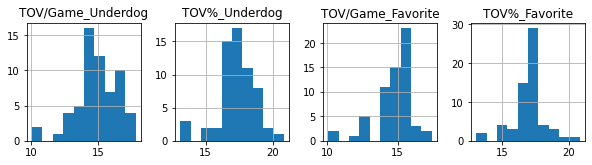

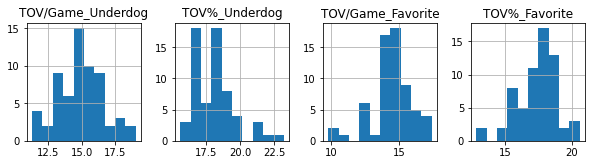

In [12]:
tov_null_years = sorted(list(set(tov_nulls_rows['Year'])))

for year in tov_null_years:
    print(f"{year} feature distributions")
    year_df = mm_matchups_df[mm_matchups_df['Year'] == year]
    year_df[tov_null_fills].hist(figsize=(10, 5), layout=(len(tov_null_years), len(tov_null_fills)))

array([[<AxesSubplot:title={'center':'PF/Game_Favorite'}>,
        <AxesSubplot:title={'center':'PF/Game_Underdog'}>]], dtype=object)

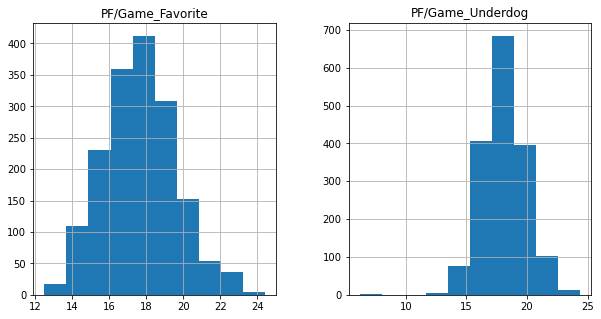

In [13]:
mm_matchups_df[pf_null_fills].hist(figsize=(10, 5), layout=(1, len(pf_null_fills)))

### Impute TOV Nulls by Season

In [14]:
tov_col_means = mm_matchups_df[tov_nulls_rows.columns].groupby('Year').mean()
tov_col_means.loc[tov_null_years]

,TOV/Game_Underdog,TOV%_Underdog,TOV/Game_Favorite,TOV%_Favorite
Year,,,,
1993,14.909836,17.281967,14.787097,17.066129
2000,14.916129,18.106452,14.520635,17.384127


In [15]:
for year in tov_null_years:
    for col in tov_null_fills:
        col_fill_rows = tov_nulls_rows[tov_nulls_rows['Year'] == year].index
        col_year_mean = np.round(tov_col_means.loc[year, col], 1)
        
        mm_matchups_df.loc[col_fill_rows, col] = mm_matchups_df.loc[col_fill_rows, col].fillna(col_year_mean)
        
mm_matchups_df.loc[tov_nulls_rows.index, tov_null_fills]

,TOV/Game_Underdog,TOV%_Underdog,TOV/Game_Favorite,TOV%_Favorite
15,14.9,17.3,15.6,17.4
16,14.9,17.3,12.0,15.9
45,17.8,16.6,14.8,17.1
481,14.9,18.1,15.8,17.8


### Impute PF Nulls Using Entire Distribution

In [16]:
pf_col_means = mm_matchups_df[pf_null_fills].mean()
pf_col_means

PF/Game_Favorite    17.635175
PF/Game_Underdog    18.108200
dtype: float64

In [17]:
for col in pf_null_fills:
    col_mean = np.round(mm_matchups_df[col].mean(), 1)
    mm_matchups_df[col].fillna(col_mean, inplace=True)
    
mm_matchups_df.loc[pf_nulls_rows.index, pf_null_fills]

,PF/Game_Favorite,PF/Game_Underdog
568,17.6,18.1
569,17.6,18.1
570,17.6,18.1
571,17.6,18.1
572,17.6,18.1
...,...,...
627,17.6,18.1
628,17.6,18.1
629,17.6,18.1
630,17.6,18.1


# Exploratory Data Analysis (EDA)

As any good data scientist should do, there are a few questions I hope to address in my EDA

## What is a Bracket's Accuracy Given Random Guessing in Favor of the Majority Class (Base Rate: Favorite Beats Underdog)?

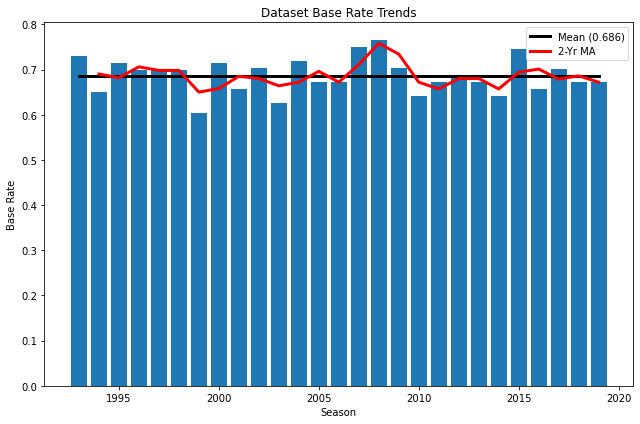

In [18]:
yearly_base_rates = get_yearly_base_rates(mm_matchups_df)
mean_base_rate = np.round(yearly_base_rates.mean(), 3)

years_ma = 2
base_rate_ma = np.round(yearly_base_rates.rolling(years_ma).mean(), 3)

plt.figure(figsize=(9, 6))

plt.plot(yearly_base_rates.index, [mean_base_rate] * len(yearly_base_rates), color='k', linewidth=3, label=f'Mean ({mean_base_rate})')
plt.plot(yearly_base_rates.index, base_rate_ma, color='r', linewidth=3, label=f'{years_ma}-Yr MA')
plt.bar(yearly_base_rates.index, yearly_base_rates)

format_plot(title='Dataset Base Rate Trends', xlabel='Season', ylabel='Base Rate')

## How Often Do Upsets Occur in a Given Year's March Madness? 

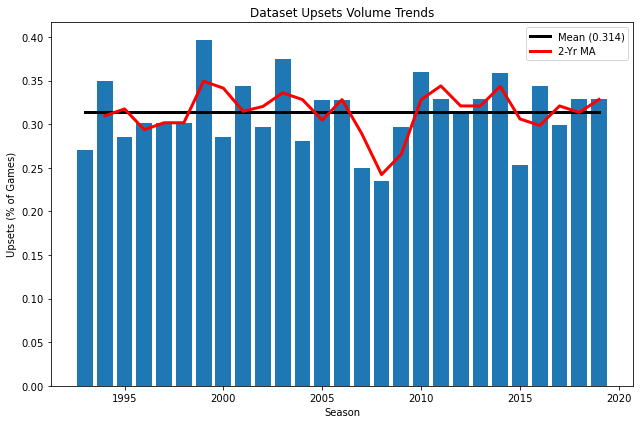

In [19]:
yearly_upsets = mm_matchups_df.groupby('Year').agg({'Underdog_Upset': ['sum', 'count']})
yearly_pct_upsets = yearly_upsets[('Underdog_Upset', 'sum')] / yearly_upsets[('Underdog_Upset', 'count')]

pct_upsets_ma = yearly_pct_upsets.rolling(years_ma).mean()
mean_pct_upsets = np.round(yearly_pct_upsets.mean(), 3)

plt.figure(figsize=(9, 6))

plt.plot(yearly_pct_upsets.index, [mean_pct_upsets] * len(yearly_pct_upsets), color='k', linewidth=3, 
         label=f'Mean ({mean_pct_upsets})')
plt.plot(yearly_pct_upsets.index, pct_upsets_ma, color='r', linewidth=3, label=f'{years_ma}-Yr MA')
plt.bar(yearly_pct_upsets.index, yearly_pct_upsets)

format_plot(title='Dataset Upsets Volume Trends', xlabel='Season', ylabel='Upsets (% of Games)')

## What is the Distribution of Upsets Across Each Tournament Round?

In [20]:
seed_pairs = get_seed_pairs(mm_matchups_df)

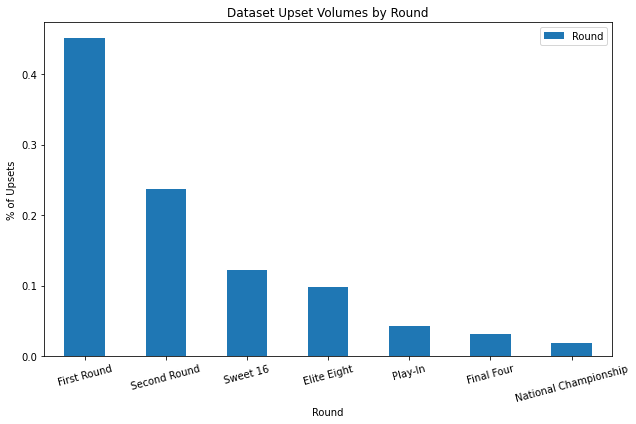

In [21]:
upset_pairs = seed_pairs[seed_pairs['Underdog_Upset'] == 1]
upset_rounds_freq = upset_pairs['Round'].value_counts(normalize=True)
upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=15)

format_plot(title='Dataset Upset Volumes by Round', xlabel='Round', ylabel='% of Upsets')

## Which Seeding Combinations are the Most Likely to Produce Upsets?

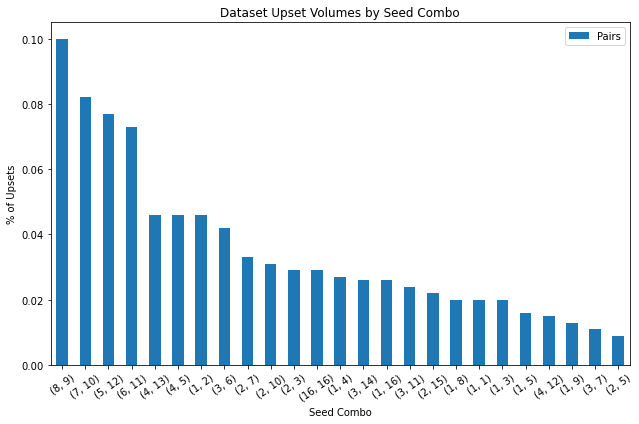

In [22]:
upset_pairs_freq = np.round(upset_pairs['Pairs'].value_counts(normalize=True)[:25], 3)
upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Dataset Upset Volumes by Seed Combo', xlabel='Seed Combo', ylabel='% of Upsets')

# Feature Engineering & Analysis

In [23]:
mm_matchups_df.drop(['Year', 'Team_Favorite', 'Team_Underdog'], axis=1, inplace=True)
all_rounds = mm_matchups_df['Round']

X = mm_matchups_df.drop('Underdog_Upset', axis=1)
y = mm_matchups_df['Underdog_Upset']

display(X), display(y)

,Round,Seed_Favorite,Seed_Underdog,G_Favorite,W-L%_Favorite,SOS_Favorite,FG%_Favorite,3P%_Favorite,FT%_Favorite,FTr_Favorite,...,Opp./Game_Underdog,FG/Game_Underdog,3P/Game_Underdog,FT/Game_Underdog,TRB/Game_Underdog,AST/Game_Underdog,STL/Game_Underdog,BLK/Game_Underdog,TOV/Game_Underdog,PF/Game_Underdog
0,National Championship,1,1,38.0,0.895,11.25,0.506,0.372,0.706,0.392,...,71.8,31.4,4.2,14.9,41.5,16.3,6.8,5.4,15.6,18.6
1,Final Four,1,1,34.0,0.882,9.23,0.480,0.394,0.688,0.359,...,71.8,31.4,4.2,14.9,41.5,16.3,6.8,5.4,15.6,18.6
2,Final Four,1,2,38.0,0.895,11.25,0.506,0.372,0.706,0.392,...,69.7,30.8,6.0,16.8,36.1,19.1,9.1,2.9,14.5,17.6
3,Elite Eight,1,2,35.0,0.886,11.09,0.522,0.425,0.717,0.459,...,69.7,30.8,6.0,16.8,36.1,19.1,9.1,2.9,14.5,17.6
4,Elite Eight,1,2,38.0,0.895,11.25,0.506,0.372,0.706,0.392,...,58.5,28.1,5.0,13.2,36.0,16.0,10.0,2.6,14.1,18.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,First Round,7,10,35.0,0.857,0.80,0.490,0.414,0.704,0.271,...,71.9,26.1,7.1,14.5,35.7,13.5,6.9,3.9,12.4,18.8
1743,First Round,6,11,36.0,0.889,2.62,0.462,0.337,0.687,0.327,...,73.4,26.4,7.1,17.6,39.7,13.5,6.3,3.2,13.7,19.9
1744,Play-In,11,11,33.0,0.818,-2.60,0.498,0.372,0.737,0.286,...,71.5,26.5,7.5,14.3,34.4,14.4,8.6,2.2,11.2,17.6
1745,Play-In,16,16,35.0,0.543,-2.07,0.454,0.365,0.777,0.318,...,66.6,25.7,6.5,13.5,37.2,15.5,6.1,2.7,15.1,17.9


0       0
1       1
2       0
3       1
4       0
       ..
1742    0
1743    0
1744    0
1745    0
1746    0
Name: Underdog_Upset, Length: 1747, dtype: int64

(None, None)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.drop('Round', axis=1, inplace=True)
X_test.drop('Round', axis=1, inplace=True)

fit_df = X_train
prep_X_train = feature_pipeline(X_train, fit_df)
prep_X_test = feature_pipeline(X_test, fit_df)

prep_all_X = pd.concat([prep_X_train, prep_X_test])
prep_all_X

,Seed_Favorite,Seed_Underdog,Underdog_Rel_W-L%,Underdog_Rel_TS%,Underdog_Rel_TRB/Game,Underdog_Rel_FT%,Underdog_Rel_AST/Game,Underdog_Rel_STL/Game,Underdog_Rel_TRB%,Underdog_Rel_PF/Game,...,Underdog_Rel_TOV%,Underdog_Rel_FT/Game,Underdog_Rel_FG%,Underdog_Rel_PtsDiff,Underdog_Rel_Top_25,Underdog_Rel_SOS,Underdog_Rel_G,Underdog_Rel_3PAr,Underdog_Rel_FG/Game,Underdog_Rel_eFG%
464,0.764333,0.020470,0.983003,1.238788,0.856410,-0.286075,1.436075,-0.895352,0.279308,0.205621,...,-0.943099,-0.803061,1.481384,1.421253,-0.933772,-0.093679,0.781430,0.553823,1.356464,1.617034
493,-0.949589,1.512430,-1.704585,-1.725750,0.962564,-1.756867,-0.959505,0.109272,0.339954,2.128119,...,1.451870,-0.239002,-1.207658,-1.254120,-0.933772,-2.583641,0.085663,-0.807550,-0.774523,-1.511301
415,-0.264020,-0.974171,0.158016,-0.656071,0.670641,0.531032,0.136777,0.209734,-0.145211,0.165569,...,-0.021957,0.475473,-0.624492,-0.253130,0.863031,0.578086,-0.957986,-1.002032,-0.064194,-0.834905
1073,0.764333,0.269130,0.353631,-0.625509,0.617565,-0.286075,-0.309856,-0.292578,-0.600052,0.646194,...,-0.298300,0.776305,-0.592094,0.110866,-0.933772,-0.573276,0.085663,-0.265779,-0.312809,-0.750355
1137,-0.264020,1.015110,0.736357,0.474732,0.644103,0.633170,-0.675284,0.812508,0.279308,0.045413,...,-0.206185,1.001928,0.379849,0.329264,0.863031,-0.985532,0.781430,0.206534,1.320948,0.320607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392,-0.264020,1.015110,0.727852,0.535857,1.068718,0.245044,1.111251,-0.493503,0.764472,-0.595419,...,0.899185,0.137038,0.865820,0.838859,-0.933772,-1.240113,0.781430,-0.515827,0.717168,0.546072
857,-0.606805,-0.974171,-0.556406,0.321921,-3.044738,0.469749,1.476678,0.109272,-4.238785,-1.196200,...,-2.416925,-1.667951,-0.170919,-0.708125,0.863031,0.968990,-0.957986,2.359726,-0.028678,0.602439
478,-0.606805,-0.725511,-0.683982,-1.786874,0.591026,-0.878477,-0.594078,-0.041422,-0.236179,0.526038,...,-0.850985,-1.291912,-1.985212,-0.471528,-0.933772,0.888510,-0.610103,1.095594,-0.419359,-1.483118
199,0.078764,0.517790,-0.488366,-0.319886,0.431796,-1.736439,0.502205,1.917595,-0.963926,0.566090,...,0.484671,0.024226,0.574237,-0.398728,0.863031,1.233425,1.129313,-0.877008,1.569563,0.066958


## What are the Distributions of all our Features?

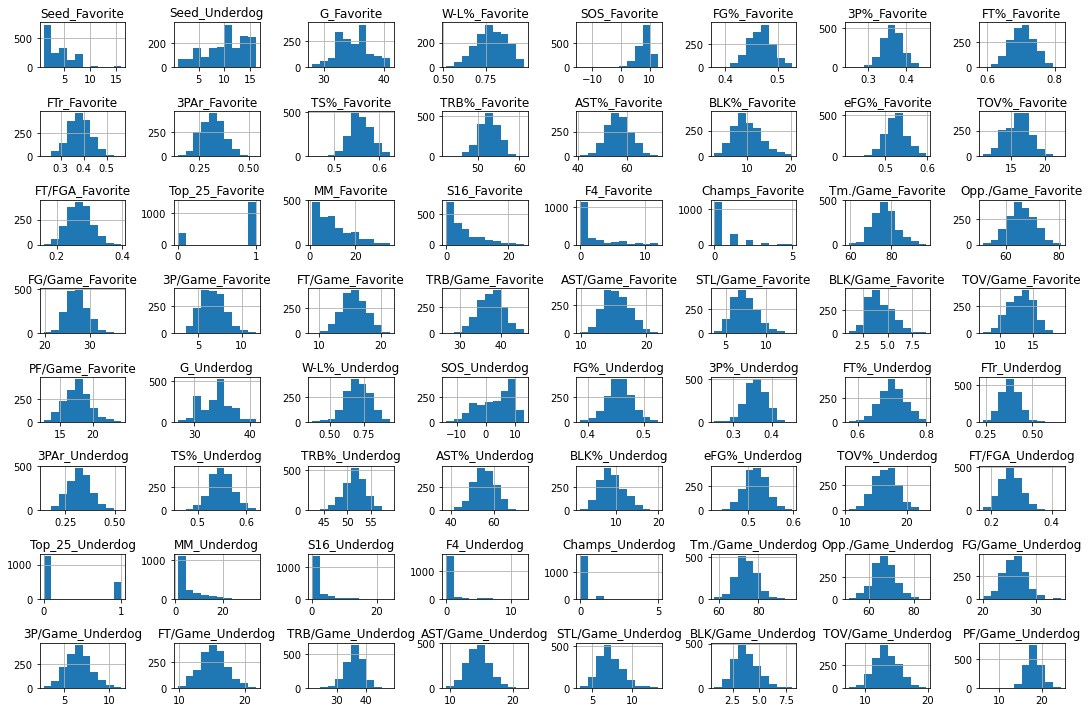

In [25]:
X.hist(figsize=(15, 10))
plt.tight_layout()

## What are the Correlations Between Features?

No handles with labels found to put in legend.


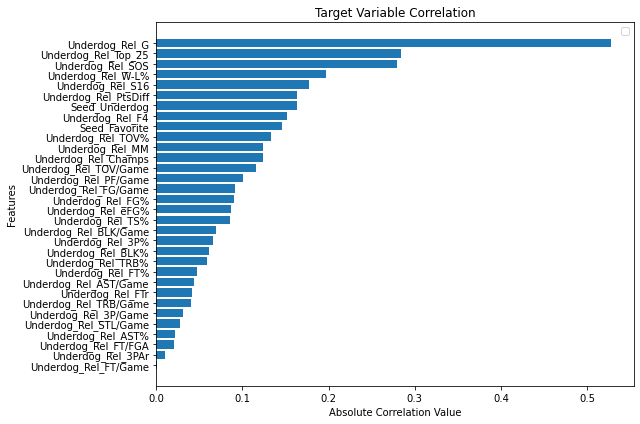

In [26]:
prep_X_y = prep_X_train.merge(y_train, left_index=True, right_index=True)
abs_desc_corr = np.abs(prep_X_y.corr().loc['Underdog_Upset']).sort_values()
abs_desc_corr.drop('Underdog_Upset', inplace=True)

plt.figure(figsize=(9, 6))
plt.barh(abs_desc_corr.index, abs_desc_corr.values)

format_plot(title='Target Variable Correlation', xlabel='Absolute Correlation Value', ylabel='Features')

## What Features have the Greatest Predictive Power?

No handles with labels found to put in legend.


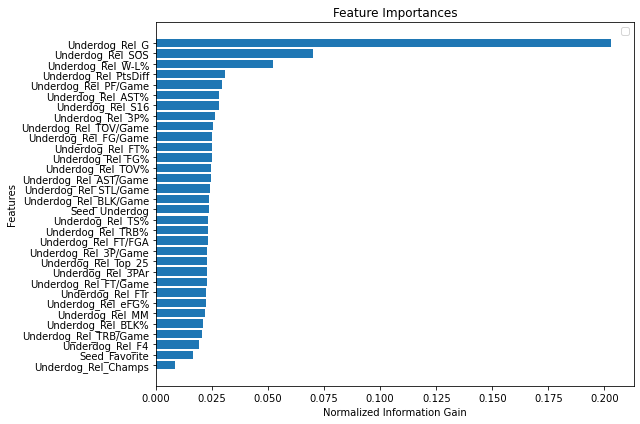

In [27]:
rf = RandomForestClassifier().fit(prep_X_train, y_train)

# Sort features & their corresponding values in by importance
importances = rf.feature_importances_
feat_importances = prep_all_X.columns[np.argsort(importances)]
feat_values = np.sort(importances)

# Plot feature importances calculated above
plt.figure(figsize=(9, 6))
plt.barh(feat_importances, feat_values)

format_plot(title='Feature Importances', xlabel='Normalized Information Gain', ylabel='Features')

# Model Selection

In [28]:
cv_models = get_cv_models(y)
model_performance = evaluate_cv_models(cv_models, prep_X_train, y_train)

model_performance

,Mean_Accuracy,Mean_Accuracy_Std,Mean_AUC,Mean_AUC_Std
KNN,0.720,0.014,0.778,0.027
Naive Bayes,0.732,0.022,0.783,0.037
LogReg,0.775,0.012,0.839,0.026
SVM,0.795,0.016,0.844,0.023
Random Forest,0.746,0.010,0.789,0.022


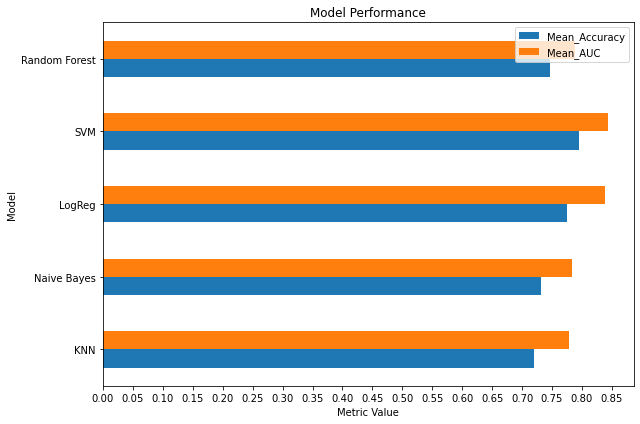

In [29]:
model_performance[['Mean_Accuracy', 'Mean_AUC']].plot(figsize=(9, 6), kind='barh', xticks=np.arange(0, 0.9, 0.05))

format_plot(title='Model Performance', xlabel='Metric Value', ylabel='Model')

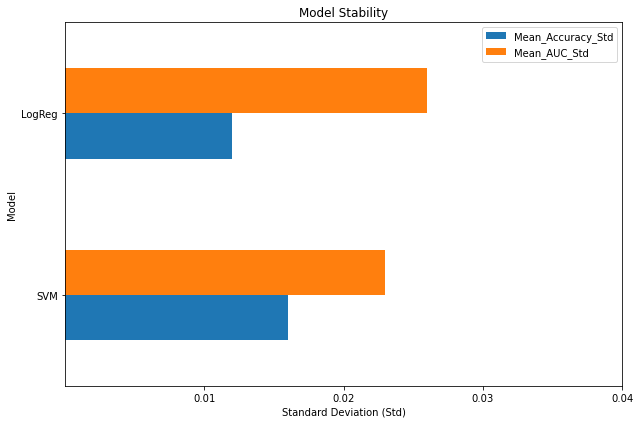

In [30]:
model_performance.loc[['SVM', 'LogReg'], ['Mean_Accuracy_Std', 'Mean_AUC_Std']].plot(
    figsize=(9, 6), kind='barh', xticks=np.arange(0.01, 0.05, 0.01)
)

format_plot(title='Model Stability', xlabel='Standard Deviation (Std)', ylabel='Model')

# Model Evaluation

In [31]:
best_model = cv_models['SVM'][-1].best_estimator_
y_preds = best_model.predict(prep_X_test)

display(best_model)

LinearSVC(C=0.1, dual=False, random_state=42)

In [32]:
test_game_data = pd.concat([y_test, all_rounds, mm_matchups_df[['Seed_Favorite', 'Seed_Underdog']]], 
                           join='inner', axis=1).drop('Underdog_Upset', axis=1)
test_game_data['Underdog_Upset'] = y_preds

test_seed_pairs = get_seed_pairs(test_game_data)

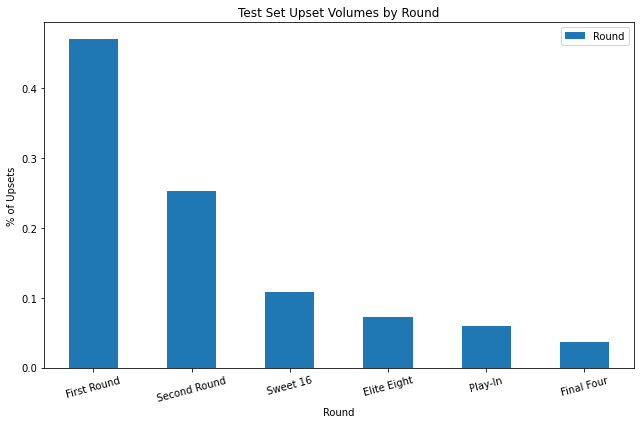

In [33]:
test_upset_pairs = test_seed_pairs[test_seed_pairs['Underdog_Upset'] == 1]
test_upset_rounds_freq = test_upset_pairs['Round'].value_counts(normalize=True)
test_upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=15)

format_plot(title='Test Set Upset Volumes by Round', xlabel='Round', ylabel='% of Upsets')

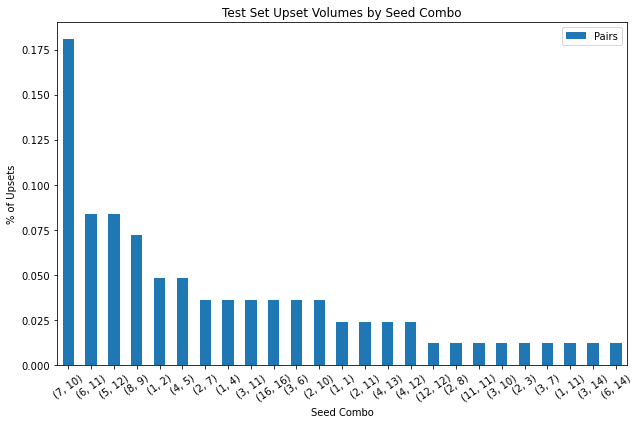

In [34]:
test_upset_pairs_freq = np.round(test_upset_pairs['Pairs'].value_counts(normalize=True)[:25], 3)
test_upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Test Set Upset Volumes by Seed Combo', xlabel='Seed Combo', ylabel='% of Upsets')

In [35]:
report = get_classification_report(y_test, y_preds)
print("Test Set Metrics Report \n\n", report)

Test Set Metrics Report 

               precision    recall  f1-score   support

           0       0.86      0.93      0.89       247
           1       0.80      0.64      0.71       103

    accuracy                           0.85       350
   macro avg       0.83      0.79      0.80       350
weighted avg       0.84      0.85      0.84       350



# 2021 March Madness Predictions

## Data Pipeline

In [36]:
try:
    curr_bracket_df = pd.read_csv(f'{curr_year}_march_madness_curr_start_bracket.csv')
except FileNotFoundError:
    curr_bracket_df = fetch.get_current_bracket('http://www.espn.com/mens-college-basketball/tournament/bracket')
    curr_bracket_df.to_csv(f'{curr_year}_march_madness_curr_start_bracket.csv', index=False)
    
play_in = curr_bracket_df[:4]
play_in = play_in.reindex([0, 1, 3, 2])

first_round = curr_bracket_df[4:]
first_round.index = range(len(first_round))

display(play_in), display(first_round)

,Seed,Team,Seed.1,Team.1
0,16,Norfolk St,16,Appalachian State
1,11,Wichita State,11,Drake
3,16,Mount St. Mary's,16,Texas Southern
2,11,Michigan State,11,UCLA


,Seed,Team,Seed.1,Team.1
0,1,Gonzaga,16,NaN
1,8,Oklahoma,9,Missouri
2,5,Creighton,12,UC Santa Barbara
3,4,Virginia,13,Ohio
4,6,USC,11,NaN
5,3,Kansas,14,Eastern Washington
6,7,Oregon,10,VCU
7,2,Iowa,15,Grand Canyon
8,1,Michigan,16,NaN
9,8,LSU,9,St. Bonaventure


(None, None)

In [37]:
bracket_preds = bracket_pipeline(curr_year, play_in, first_round, best_model, fit_df, null_drops)
display(bracket_preds)

,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
0,16,Norfolk St,16,Appalachian State,Play-In,1,Appalachian State
1,11,Drake,11,Wichita State,Play-In,0,Drake
2,16,Texas Southern,16,Mount St. Mary's,Play-In,0,Texas Southern
3,11,UCLA,11,Michigan State,Play-In,0,UCLA
4,1,Gonzaga,16,Appalachian State,First Round,0,Gonzaga
...,...,...,...,...,...,...,...
62,2,Ohio State,9,Wisconsin,Elite Eight,1,Wisconsin
63,2,Houston,12,Oregon State,Elite Eight,1,Oregon State
64,6,USC,11,UCLA,Final Four,0,USC
65,9,Wisconsin,12,Oregon State,Final Four,1,Oregon State


## Pre-Tournament Model Evaluation (3/17/21)

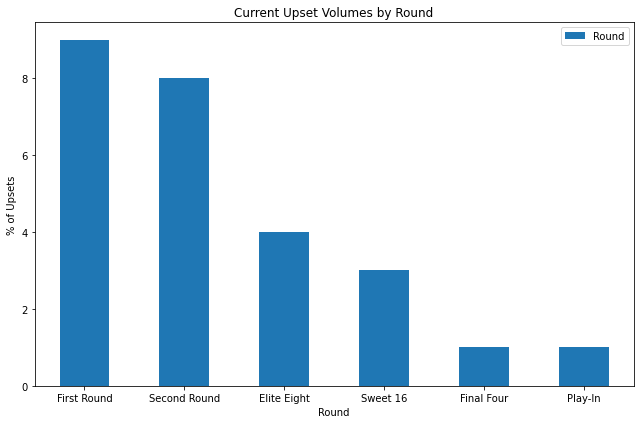

In [38]:
curr_seed_pairs = get_seed_pairs(bracket_preds)
curr_upset_pairs = curr_seed_pairs[curr_seed_pairs['Underdog_Upset'] == 1]

curr_upset_rounds_freq = curr_upset_pairs['Round'].value_counts()
curr_upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=0)

format_plot(title='Current Upset Volumes by Round', xlabel='Round', ylabel='% of Upsets')

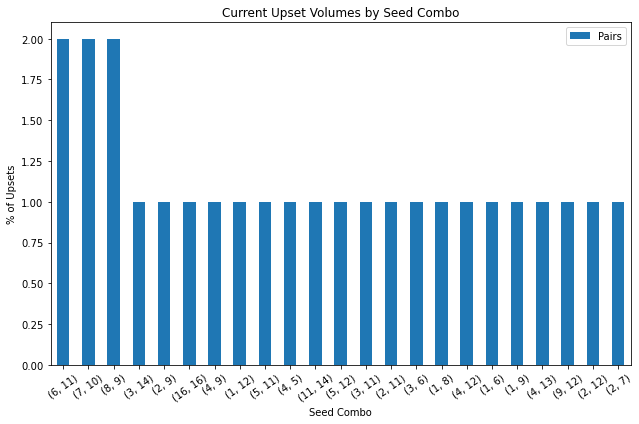

In [39]:
curr_seed_pairs = get_seed_pairs(bracket_preds)
curr_upset_pairs = curr_seed_pairs[curr_seed_pairs['Underdog_Upset'] == 1]

curr_upset_pairs_freq = curr_upset_pairs['Pairs'].value_counts()
curr_upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Current Upset Volumes by Seed Combo', xlabel='Seed Combo', ylabel='% of Upsets')

In [40]:
for _round in bracket_preds['Round'].unique():
    display(bracket_preds[bracket_preds['Round'] == _round])

,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
0,16,Norfolk St,16,Appalachian State,Play-In,1,Appalachian State
1,11,Drake,11,Wichita State,Play-In,0,Drake
2,16,Texas Southern,16,Mount St. Mary's,Play-In,0,Texas Southern
3,11,UCLA,11,Michigan State,Play-In,0,UCLA


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
4,1,Gonzaga,16,Appalachian State,First Round,0,Gonzaga
5,8,Oklahoma,9,Missouri,First Round,1,Missouri
6,5,Creighton,12,UC Santa Barbara,First Round,0,Creighton
7,4,Virginia,13,Ohio,First Round,0,Virginia
8,6,USC,11,Drake,First Round,0,USC
9,3,Kansas,14,Eastern Washington,First Round,0,Kansas
10,7,Oregon,10,VCU,First Round,0,Oregon
11,2,Iowa,15,Grand Canyon,First Round,0,Iowa
12,1,Michigan,16,Texas Southern,First Round,0,Michigan
13,8,LSU,9,St. Bonaventure,First Round,0,LSU


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
36,1,Gonzaga,9,Missouri,Second Round,0,Gonzaga
37,4,Virginia,5,Creighton,Second Round,1,Creighton
38,3,Kansas,6,USC,Second Round,1,USC
39,2,Iowa,7,Oregon,Second Round,1,Oregon
40,1,Michigan,8,LSU,Second Round,1,LSU
41,5,Colorado,13,UNC Greensboro,Second Round,0,Colorado
42,3,Texas,11,UCLA,Second Round,1,UCLA
43,2,Alabama,10,Maryland,Second Round,0,Alabama
44,1,Baylor,9,Wisconsin,Second Round,1,Wisconsin
45,4,Purdue,5,Villanova,Second Round,0,Purdue


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
52,1,Gonzaga,5,Creighton,Sweet 16,0,Gonzaga
53,6,USC,7,Oregon,Sweet 16,0,USC
54,5,Colorado,8,LSU,Sweet 16,0,Colorado
55,2,Alabama,11,UCLA,Sweet 16,1,UCLA
56,4,Purdue,9,Wisconsin,Sweet 16,1,Wisconsin
57,2,Ohio State,3,Arkansas,Sweet 16,0,Ohio State
58,1,Illinois,12,Oregon State,Sweet 16,1,Oregon State
59,2,Houston,14,Morehead State,Sweet 16,0,Houston


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
60,1,Gonzaga,6,USC,Elite Eight,1,USC
61,5,Colorado,11,UCLA,Elite Eight,1,UCLA
62,2,Ohio State,9,Wisconsin,Elite Eight,1,Wisconsin
63,2,Houston,12,Oregon State,Elite Eight,1,Oregon State


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
64,6,USC,11,UCLA,Final Four,0,USC
65,9,Wisconsin,12,Oregon State,Final Four,1,Oregon State


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
66,6,USC,12,Oregon State,National Championship,0,USC


## Post-Tournament Model Evaluation